In [1]:
from numpy import *
from matplotlib import *
from pylab import *
from scipy import *
from numpy import*
import csv
import xlrd

rc('text',usetex = True)
rc('font', family='serif')

from scipy.optimize import curve_fit
from scipy import integrate
from scipy.optimize import fsolve
import xlsxwriter

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [2]:
def Prop_int(Prop,T,B,T_int,B_int):
    i = 0
    i_int = 0
    while T_int > T[i]:
            i_int = i
            i = i+1
    j = 0 
    j_int = 0
    while B_int > B[j]:
            j_int = j
            j = j+1
                   
    Prop_int  = Prop[j_int+1][i_int] 
    return Prop_int

In [3]:
def H_eff(H,Tc,Th,n,M):
    N_cas = (2*n/np.sqrt(np.pi))*(2*(2*n/(np.sqrt(np.pi)))+1)**-1
    N_t = 0.365 #1/3 + (1-0.36)*(N_cas-1/3)
    T_e = np.arange(Tc,Th+0.01,0.1)
    M_eff = zeros([len(H),len(T_e)]) 
    H_eff = zeros([len(H),len(T_e)])
    for i in range(len(H)):
        for j in range(len(T_e)):
            M_eff[i][j] = Prop_int(M_m,T,B,T_e[j],H[i])*4*np.pi*10**-7
            H_ef = fsolve(lambda H_ef: f(H_ef,M_m,T,B,H[i],T_e[j],N_t),H[i])
            #print(H_ef)
            H_eff[i][j] = H_ef
            
    return (H_eff)

In [4]:
def Mean_C(T,B,H,Tc,Th,n,cp_m):

    T_p = np.arange(Tc,Th+0.01,0.1)
    H_e = H_eff(H,Tc,Th,n,M_m)
    
    C_low = []
    C_high = []
    
    
    for i in range(len(T_p)):
        #print(H_e[0][i])
        C_low.append(Prop_int(cp_m,T,B,T_p[i],H_e[0][i]))
        C_high.append(Prop_int(cp_m,T,B,T_p[i],H_e[1][i]))

    C_low_mean = integrate.simps(C_low,T_p)/(Th-Tc)
    C_high_mean = integrate.simps(C_high,T_p)/(Th-Tc)
    return(C_low_mean,C_high_mean)

In [5]:
def Mean_dT(T,B,Tc,Th,H,n,dT_m,T_dm):
    
    T_p = np.arange(Tc,Th+0.01,0.1)
    
    H_e = H_eff(H,Tc,Th,n,M_m)
    
    dT_low_mag = []
    dT_high_mag = []
    dT_low_dmag = []
    dT_high_dmag = []

    
    for i in range(len(T_p)):
        j = 0
        j_l = 0
        
        while H_e[0][i] > B[j]:
            j_l = j
            j = j+1
    
        j_h = 0
        
        while H_e[1][i] > B[j]:
            j_h = j
            j = j+1
            
        dT_low_mag.append(Prop_int(dT_m,T,B,T_p[i],H_e[0][i]))
        dT_high_mag.append(Prop_int(dT_m,T,B,T_p[i],H_e[1][i]))
        dT_low_dmag.append(Prop_int(dT_m,T_dm[j_l],B,T_p[i],H_e[0][i]))
        dT_high_dmag.append(Prop_int(dT_m,T_dm[j_h],B,T_p[i],H_e[1][i]))
        
    dT_mag = np.array(dT_high_mag) - np.array(dT_low_mag)
    dT_dmag = np.array(dT_high_dmag) - np.array(dT_low_dmag)
    
    dT_mag_mean = integrate.simps(dT_mag,T_p)/(Th-Tc)
    dT_dmag_mean = integrate.simps(dT_dmag,T_p)/(Th-Tc)
    
    return(dT_mag_mean,dT_dmag_mean)

In [6]:
def f(H_ef,M_m,T,B,H_ap,T_in,N_t):
    f = H_ef +Prop_int(M_m,T,B,T_in,H_ef)*4*np.pi*10**-7*N_t - H_ap
    return f

In [7]:
workbook = xlrd.open_workbook('Tc_290.xlsx')
Prop = workbook.sheet_by_name('Prop')

In [8]:
workbook = xlrd.open_workbook('Data_Jaime_2014.xlsx')
worksheet = workbook.sheet_by_name('Plan2')

In [9]:
T = np.arange(242.5,309.59,0.1)
B = np.arange(0,2.001,0.01)

In [10]:
N =len(Prop.col(0))

T_v = []
B_v = []
cp_v = []
dS_v = []
dT_v = []
M_v = []

for i in range(N):
    T_v.append(Prop.cell(i,0).value)
    B_v.append(Prop.cell(i,1).value)
    cp_v.append(Prop.cell(i,2).value)
    dS_v.append(Prop.cell(i,3).value)
    dT_v.append(Prop.cell(i,4).value)
    M_v.append(Prop.cell(i,5).value)

In [11]:
cp_m = zeros([len(B),len(T)])
dS_m = zeros([len(B),len(T)])
dT_m = zeros([len(B),len(T)])
M_m  = zeros([len(B),len(T)])

cp_a = np.array(cp_v)
dS_a = np.array(dS_v)
dT_a = np.array(dT_v)
M_a = np.array(M_v)

for k in range(len(B)):
    cp_m[k] = cp_a[len(T)*k:len(T)*(k+1)]
    dS_m[k] = dS_a[len(T)*k:len(T)*(k+1)]
    dT_m[k] = dT_a[len(T)*k:len(T)*(k+1)]
    M_m[k] = M_a[len(T)*k:len(T)*(k+1)]      

In [12]:
H = [0.01,1.2]
T_dm = T+dT_m

In [13]:
N1 = 29
dT = zeros(N1)
Th = zeros(N1)

for i in range(0,N1):
    Th[i] = worksheet.cell(i, 0).value
    dT[i] = worksheet.cell(i, 1).value

In [14]:
for i in range(N1):
    if dT[i] <0.1:
        dT[i] = 0.2

Tc = Th - dT

In [15]:
C_low = zeros(N1)
C_high = zeros(N1)


dT_mag = zeros(N1)
dT_dmag = zeros(N1)

for i in range(N1):
    print(i)
    C_low[i],C_high[i] = Mean_C(T,B,H,Tc[i],Th[i],100/22.4,cp_m)
    dT_mag[i],dT_dmag[i]     = Mean_dT(T,B,Tc[i],Th[i],H,100/22.4,dT_m,T_dm)

0


C:\Users\Usuario\Anaconda_new\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Usuario\Anaconda_new\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [20]:
workbook = xlsxwriter.Workbook('C_h.xlsx')
Data = workbook.add_worksheet('C')

for i in range(N1):
    Data.write(i, 0,C_low[i])
    Data.write(i, 1,C_high[i])
    Data.write(i, 2,dT_mag[i])
    Data.write(i, 3,dT_dmag[i])

In [17]:
[A,B] = H_eff(H,270,280,100/25,M_v)

C:\Users\Usuario\Anaconda_new\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


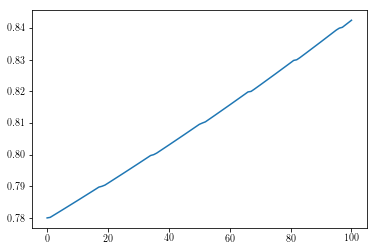

In [18]:
plt.plot(B)